### Project: Material Surface defect classification using CNN and SVM

**Data set Link** : https://www.kaggle.com/arunrk7/surface-crack-detection



### Importing all the libraries required for the classification

In [27]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

import numpy as np
import cv2
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.regularizers import l2
from keras.utils.vis_utils import plot_model
from tensorflow.keras.preprocessing import image

import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
tf.__version__

'2.3.0'

### **Part 1 - Data Preprocessing**

In [2]:
train_path = 'C:/Users/hp/Desktop/ML_Project/crack_detection/Train'
test_path =  'C:/Users/hp/Desktop/ML_Project/crack_detection/Test'

In [3]:
# Preprocessing the Training set
train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
training_set=train_datagen.flow_from_directory(train_path,target_size = (64, 64), batch_size = 32, class_mode='binary')

Found 800 images belonging to 2 classes.


In [4]:
training_set.class_indices

{'Negative': 0, 'Positive': 1}

In [5]:
# Preprocessing the Test set
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set=test_datagen.flow_from_directory(test_path, target_size = (64, 64), batch_size = 32,class_mode = 'binary')

Found 400 images belonging to 2 classes.


In [6]:
test_set.class_indices

{'Negative': 0, 'Positive': 1}

### **Part 2 - Building the CNN**

In [7]:
# Initialising the CNN
cnn = Sequential()

# Step 1 - Convolution
cnn.add(Conv2D(filters=32,padding="same",kernel_size=3, activation='relu', strides=2, input_shape=[64, 64, 3]))

# Step 2 - Pooling
cnn.add(MaxPooling2D(pool_size=2, strides=2))

# Adding a second convolutional layer
cnn.add(Conv2D(filters=32,padding='same',kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=2, strides=2))

# Step 3 - Flattening
cnn.add(Flatten())

# Step 4 - Full Connection
cnn.add(Dense(units=128, activation='relu'))

# Step 5 - Output Layer

## For Binary Classification
cnn.add(Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='linear'))

## for mulitclassification
# cnn.add(Dense(3, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='softmax'))

In [8]:
# Compiling the CNN
cnn.compile(optimizer = 'adam', loss = 'hinge', metrics = ['accuracy'])

### **Note:**
If we mention activation function as **linear** in final output layer of CNN and loss as **hinge** during compiling, then final layer automatically considered as SVM layer for classification.

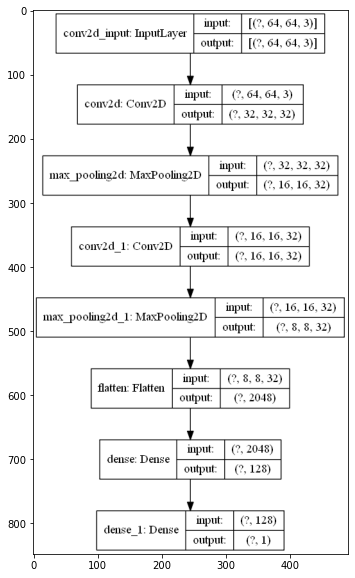

In [9]:
plot_model(cnn, to_file='LittleVGG.png', show_shapes=True, show_layer_names=True)
img = mpimg.imread('LittleVGG.png')
plt.figure(figsize=(40,10))
imgplot = plt.imshow(img)

### **Part 3 - Training the CNN**

In [10]:
# Training the CNN on the Training set and evaluating it on the Test set
r=cnn.fit(x = training_set, validation_data = test_set, epochs = 20)

Epoch 1/20
25/25 [==============================] - 10s 402ms/step - loss: 0.8915 - accuracy: 0.5038 - val_loss: 0.8364 - val_accuracy: 0.5000
Epoch 2/20
25/25 [==============================] - 9s 362ms/step - loss: 0.4237 - accuracy: 0.7925 - val_loss: 0.1561 - val_accuracy: 0.9425
Epoch 3/20
25/25 [==============================] - 9s 366ms/step - loss: 0.1543 - accuracy: 0.9375 - val_loss: 0.2010 - val_accuracy: 0.9600
Epoch 4/20
25/25 [==============================] - 9s 372ms/step - loss: 0.1058 - accuracy: 0.9513 - val_loss: 0.0910 - val_accuracy: 0.9750
Epoch 5/20
25/25 [==============================] - 9s 364ms/step - loss: 0.0767 - accuracy: 0.9650 - val_loss: 0.0846 - val_accuracy: 0.9775
Epoch 6/20
25/25 [==============================] - 9s 360ms/step - loss: 0.0856 - accuracy: 0.9625 - val_loss: 0.1075 - val_accuracy: 0.9700
Epoch 7/20
25/25 [==============================] - 9s 364ms/step - loss: 0.0644 - accuracy: 0.9737 - val_loss: 0.1591 - val_accuracy: 0.9650
Epoch

In [33]:
accuracy = r.history['accuracy'][-1]
print('Accuracy:', accuracy)

Accuracy: 0.9862499833106995


**Plotting Training and Validation accuracies and losses**

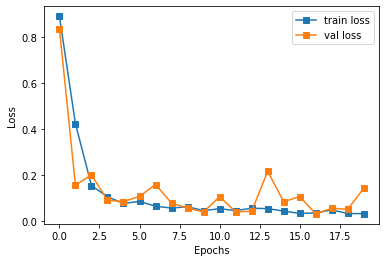

In [29]:
# plot the loss
plt.plot(r.history['loss'], label='train loss',marker='s')
plt.plot(r.history['val_loss'], label='val loss',marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

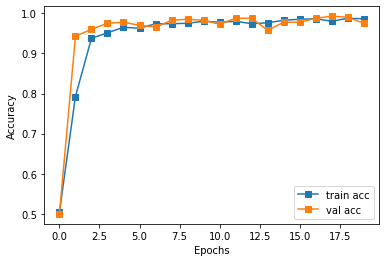

In [30]:
# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc',marker='s')
plt.plot(r.history['val_accuracy'], label='val acc',marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### **Part 4 - Finding Model performance**

**Finding Confusion Matrix**

Found 400 images belonging to 2 classes.


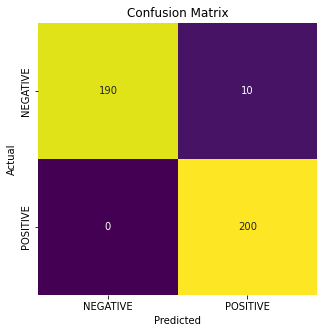

In [20]:
# We need to recreate our validation generator with shuffle = false
test_set=test_datagen.flow_from_directory(test_path, target_size = (64, 64),batch_size = 32,class_mode = 'binary',shuffle=False)

y_pred = np.squeeze((cnn.predict(test_set)>= 0.5).astype(np.int32))
cm = confusion_matrix(test_set.labels, y_pred)
clr = classification_report(test_set.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])
    
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='viridis', cbar=False)

plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

**Classification Report**

In [21]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       1.00      0.95      0.97       200
    POSITIVE       0.95      1.00      0.98       200

    accuracy                           0.97       400
   macro avg       0.98      0.97      0.97       400
weighted avg       0.98      0.97      0.97       400



### **Part 5 - Making a single prediction to check whether trained model is performing correctly**

The image classified is Non Defective


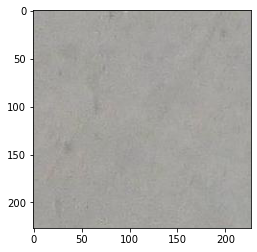

In [23]:
image_path = 'C:/Users/hp/Desktop/ML_Project/crack_detection/Test/Negative/00508.jpg'
# image_path = 'C:/Users/hp/Desktop/ML_Project/crack_detection/Test/Positive/00404.jpg'
test_image = image.load_img(image_path , target_size = (64,64))
test_image = image.img_to_array(test_image)
test_image = test_image/255
test_image = np.expand_dims(test_image, axis = 0)
result = cnn.predict(test_image)
img = cv2.imread(image_path )
# print(type(img))
plt.imshow(img)

if result[0]<0:
    print("The image classified is Non Defective")
else:
    print("The image classified is Defective")

### **Part 6 - Saving Final Model for deployment**
**Based on Classification report and Confusion Matrix, if we find that the model is performing well, we can save the model for deployment and can be used for related application**

In [22]:
# save it as a h5 file
from tensorflow.keras.models import load_model
cnn.save('model_rPositive_Negative.h5')
# load model
#from tensorflow.keras.models import load_model
#model = load_model('model_rPositive_Negative.h5')

--------
#### Another way to write a code to find Confusion Matrix

Found 400 images belonging to 2 classes.
Confusion Matrix:
-----------------


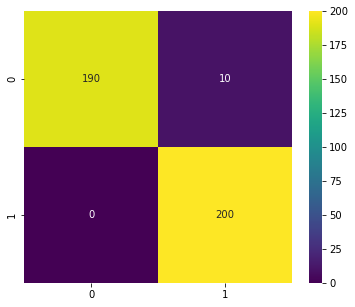

In [58]:
# We need to recreate our validation generator with shuffle = false
test_set=test_datagen.flow_from_directory(test_path, target_size = (64, 64), batch_size=32, class_mode='binary',shuffle=False)

y_pred = np.squeeze(cnn.predict(test_set)>=0.5).astype(np.int32)

# print("Confusion Matrix:\n-----------------\n", confusion_matrix(test_set.classes, y_pred))

plt.figure(figsize=(6, 5))
print("Confusion Matrix:\n-----------------")
sns.heatmap(confusion_matrix(test_set.classes, y_pred), annot=True, fmt='g', vmin=0, cmap='viridis', cbar=True);

-----
## Thank You.....